## Exploratory data analysis of the Kaggle Cancer Dataset

### Table of Contents
1. [Discription the data](#1)
2. [Distribution of classes within unique genes](#1.1) 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
plt.style.use('ggplot')

### Discribing the data <a id=1></a>

We can first load the data and see how the features look.  We can see there are three columns per dataframe, and 3321 rows, and nine classes to predict.

In [2]:
df_text = pd.read_csv('../data/training_text.csv',delimiter='\|\|',index_col=0)
df_variants = pd.read_csv('../data/training_variants.csv',index_col=0)
print(df_variants.shape)
df_variants.head(5)

C:\Users\Michael\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


(3321, 3)


,Gene,Variation,Class
ID,,,
0,FAM58A,Truncating Mutations,1
1,CBL,W802*,2
2,CBL,Q249E,2
3,CBL,N454D,3
4,CBL,L399V,4


The classes are not uniformly distributed.  Instead class 7 is around 100x more likely than class 8

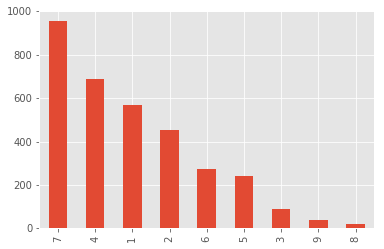

In [3]:
df_variants.Class.value_counts().plot(kind='bar',)

We can also explore how many variations per gene there are.  We can see that most of the genes only have a small number of variations attached to them.  However, some of the genes have a large amount of variations attached (ie. up to 250 variations in one gene)

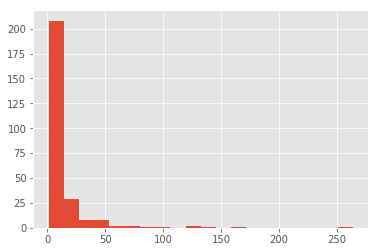

the mean number of variations per class is 12.580 +/- 26.562


In [4]:
m = df_variants.groupby('Gene').Variation.count()
m.hist(bins=20)
plt.show()
print('the mean number of variations per class is {:.3f} +/- {:.3f}'.format(m.mean(),m.std()))

In [5]:
df_variants.Gene.unique().shape

(264,)

### The effect of gene on class <a id=1.1></a>

We can ask if the class is dependent on the gene.  Ie if you have two variations within a gene, are these more likely to share a Class then two variations which don't belong to the same gene.  To do this we will run a chi-squared test on the data.  We will first split the classes up into nine features, groupby the genes, and then find the total number variations per each gene and class.   We will then create a chi-squared test using this data.

In [6]:
cm = pd.get_dummies(df_variants[['Gene','Class']],columns=['Class']).groupby('Gene').sum().values.T
cm

array([[ 0,  0,  4, ...,  0,  2,  0],
       [24,  1,  1, ...,  1,  0,  3],
       [ 0,  0,  0, ...,  0,  0,  0],
       ..., 
       [ 2,  2,  0, ...,  0,  0,  1],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

In [7]:
from scipy import stats
total_per_gene = cm.sum(axis=0)
total_per_class = cm.sum(axis=1).reshape(-1,1)
class_probs = total_per_class/total_per_class.sum()
expected = total_per_gene*class_probs
chi_square_value = ((cm - expected)**2/expected).sum()
dof = (cm.shape[0]-1)*(cm.shape[1]-1)
p_value = 1-stats.chi2.cdf(((cm - expected)**2/expected).sum(),dof)
print('The chi squared value is {:.1f} with {:d} degrees of freedom which corresponds to a p value of {:.3f}'.\
     format(chi_square_value,dof,p_value))

The chi squared value is 10042.3 with 2104 degrees of freedom which corresponds to a p value of 0.000


From this we can see that the class is not independent of the gene, and that knowing the gene does give us additional information on the class

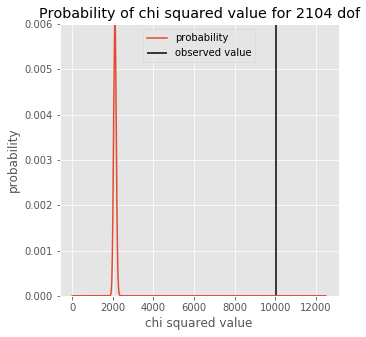

In [8]:
fig,ax = plt.subplots(figsize=(5,5))
x = np.linspace(0,12500,1000)
ax.plot(x,stats.chi2.pdf(x,dof),label='probability')
ax.set_ylabel('probability')
ax.set_xlabel('chi squared value')
ax.set_title('Probability of chi squared value for 2104 dof')
ax.vlines(chi_square_value,0,.01,label='observed value')
ax.legend(loc='upper center')
ax.set_ylim(0,.006)
plt.show()